<a href="https://colab.research.google.com/github/M-Amrollahi/Personal-Notes/blob/master/ML-notes/circle_generator_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import torch
import torch.nn as nn
import random
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
def f_createRandomImage():
    x,y = 35,35
    max_r = 10
    rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
    colors = [((255, 255, 0),0),((120, 255,0),1),(( 255, 120,0),2),((0,255, 255),3),((0, 60, 60),4)]
    lst_res = []
    for color in colors:
        for i in range(2000):
            
            frame = np.full((x,y,3),0,dtype="uint8")

            locx = random.randint(*rangex)
            locy = random.randint(*rangey)
            r = random.randint(8,max_r)
            
            
            cv2.circle(frame,(locx,locy),r,color[0],-1)

            frame = frame / 255.0
            #cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
            lst_res.append([frame.transpose(2,0,1), locx-r, locy-r, locx + r, locy + r, torch.nn.functional.one_hot(torch.tensor(color[1]), num_classes=5)])
            #cv2.waitKey(0)

    return lst_res

In [119]:
class cls_modelD(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6,kernel_size=(3,3)),
            nn.BatchNorm2d(6),
            nn.ReLU(),

            nn.Conv2d(in_channels=6, out_channels=12,kernel_size=(3,3)),
            nn.BatchNorm2d(12),
            nn.ReLU(),

            nn.MaxPool2d(2,2),

            nn.Flatten(1),

            nn.Linear(15*15*12,128),
            nn.ReLU(),

            nn.Linear(128,2),
            

        )

    def forward(self, x):
        return self.model.forward(x)

In [120]:
class cls_modelG(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.linModel = nn.Sequential( nn.Linear(20,39*39*3), nn.Tanh())

        self.model = nn.Sequential(
            
            # state size. (ngf*4) x 8 x 8
            #nn.ConvTranspose2d( 3, 3, 1,bias=False),
            #nn.BatchNorm2d(3),
            #nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            # state size. (ngf) x 32 x 32
            #nn.ConvTranspose2d( 3, 3, 1,bias=False),
            
            nn.Conv2d(3,6,3),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            #nn.Conv2d(3,3,1),
            
            #nn.ReLU(True),
            #nn.ReLU(),
            nn.Conv2d(6, 3, 3),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        x = self.linModel(x)
        x = x.reshape(x.shape[0], 3,39,39)
        return self.model.forward(x)

In [121]:
class cls_data(Dataset):
    def __init__(self,x) -> None:
        super().__init__()

        self.dataset = x
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        
        return torch.tensor(self.dataset.loc[index, "c"]).unsqueeze(dim=0), torch.tensor(self.dataset.loc[index, "image"]).permute((2,0,1)).int32()

In [122]:
lst_data = f_createRandomImage()

x = torch.tensor([i[0] for i in lst_data]).float()
x = x[torch.randperm(len(lst_data))]

trainLoader = DataLoader(x, batch_size=128)

In [123]:
modelD = cls_modelD()
criterion = nn.CrossEntropyLoss()
optimD = torch.optim.Adam(modelD.parameters(), lr=1e-4)

modelG = cls_modelG()
optimG = torch.optim.Adam(modelG.parameters(), lr=1e-4)

In [124]:
real_label = 1
fake_label = 0

In [125]:
# Training Loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

modelD = modelD.to(device)
modelG = modelG.to(device)
print("Starting Training Loop...")
# For each epoch
for epoch in range(30):
    # For each batch in the dataloader
    sum_err = 0
    
    for i, data in enumerate(trainLoader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        optimD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.int64, device=device)
        # Forward pass real batch through D
        output = modelD(real_cpu)
        # Calculate loss on all-real batch
        
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #if i==0:
        noise = torch.randn(b_size, 20, device=device)
        # Generate fake image batch with G
        fake = modelG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = modelD(fake.detach())
        # Calculate D's loss on the all-fake batch
        
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = modelD(fake)
        # Calculate G's loss based on this output
        
        
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimG.step()

        sum_err += errG.detach().cpu().item()
    
    print(sum_err/i)

Starting Training Loop...
3.936772910448221
5.8774270705687695
6.518033229387724
6.89789325151688
7.332751769285935
7.665589772737944
7.95659789060935
8.197480097795145
8.570283027795645
8.94247538004166
9.448602982056446
9.589136979518793
9.359259788806622
8.742625835614326
8.862758343036358
9.06993045562353
9.165886646662003
9.217141750531319
9.2841980273907
9.319513333149445
9.348309321281237
9.39358576750144
9.387055274767754
9.416189413804274
9.563934252812313
9.776447002704327
10.087931816394512
10.343956543849064
10.558519436762882
10.718859183482635


In [105]:
label.shape
real_cpu.shape

torch.Size([8, 3, 35, 35])

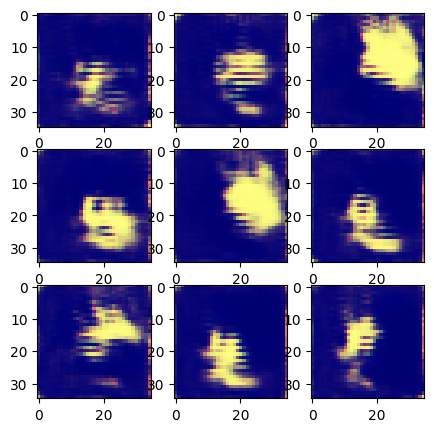

In [130]:
modelG.eval()
fixed_noise = torch.randn(9,20).to(device)

res = modelG(fixed_noise)
res = res*255
res = res.type(torch.uint8)

fig, ax = plt.subplots(3,3,figsize = (5,5))
ax = ax.ravel()
for i in range(len(res)):
    ax[i].imshow(res[i].permute(1,2,0).detach().cpu().numpy())

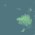

In [ ]:
Image.fromarray(res[6].permute(1,2,0).detach().cpu().numpy())

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
a = torch.arange(20,30).reshape(5,-1)
a[torch.randperm(5)]


tensor([[26, 27],
        [28, 29],
        [22, 23],
        [20, 21],
        [24, 25]])